# 配对交易简介
By Delaney Mackenzie and Maxwell Margenot

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)



配对交易是基于数学分析的经典策略。其原理如下。假设你有一对证券X和Y它们有某种潜在的经济联系。一个例子可能是两个公司生产相同的产品，或两个公司在一个供应链。如果我们能用数学模型来模拟这种经济联系，我们就可以在这种联系上进行交易。我们将从构建一个玩具示例开始。

在我们继续之前，请注意这节课的内容在很大程度上依赖于[平稳性、单整和协整](https://www.quantopian.com/lectures/integrcointegring-andarity)，以便正确理解我们在这里使用的方法的数学基础。我建议你在继续上课之前把那堂课复习一遍.

In [1]:

import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

## 产生两种虚假证券
我们用正态分布来模拟X的日收益率。然后我们执行一个累积和来得到每天X的值。

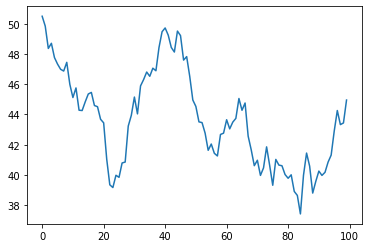

In [2]:
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot();

现在我们得到Y，记住，Y应该和X有很深的经济联系，所以Y的价格应该有相似的变化。我们通过取X，向上平移，加上正态分布中的随机噪声来建模。

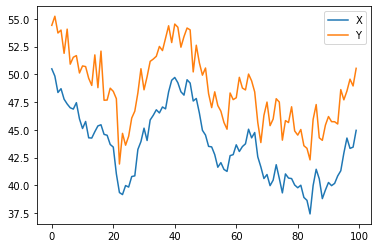

In [3]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot();

## 协整
我们构造了两个上积分级数的例子。协整是一种比相关性更微妙的关系。如果两个时间序列是协整的，它们之间存在某种线性组合，在均值附近变化。在任何时间点上，它们之间的组合都与相同的概率分布有关。

关于我们如何正式地定义协整以及如何理解它的更多细节，请参阅来自quant系列讲座的[单整、协整和平稳性](https://www.quantopian.com/lectures#Integration,-Cointegration,-and-Stationarity)。

我们现在来画出两者的区别，这样我们就能看到它是怎样的。

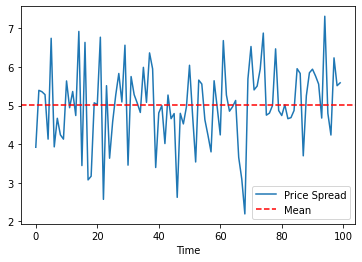

In [4]:
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean']);

## 协整检验
这是一个直观的定义，但我们如何在统计学上检验它呢?在statsmodel .tsa.stattools中有一个方便的协整测试。假设我们的置信水平是$0.05$。我们应该看到p值低于临界值，因为我们已经创建了两个系列，它们是教科书上关于协整的定义。

In [5]:
# compute the p-value of the cointegration test
# will inform us as to whether the spread between the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)
print (pvalue)

2.0503418653415035e-16


### 相关性与协整
相关性和协整虽然在理论上相似，但并不相同。为了演示这一点，我们将展示相关但没有协整的系列的例子，反之亦然。首先，让我们检查一下刚才生成的级数的相关性。

In [6]:
X.corr(Y)

0.9497090646385932

正如我们所预料的那样，这个数字非常高。但是两个相关但没有协整的系列看起来会是什么样子呢? 

### 相关而不协整
一个简单的例子是两个序列发散。

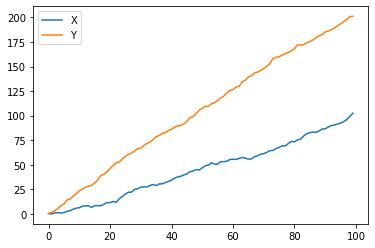

In [7]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot();

In [8]:
print( 'Correlation: ' ,X_diverging.corr(Y_diverging))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print( 'Cointegration test p-value: ' ,pvalue)

Correlation:  0.9931343801275687
Cointegration test p-value:  0.881555767469521


### 协整而没有相关性
这种情况的一个简单例子是正态分布的序列和方波。

In [9]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

In [10]:
# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

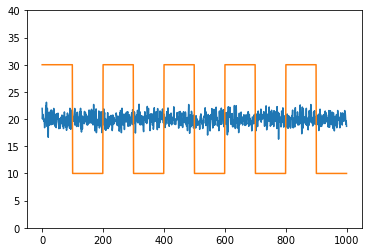

In [11]:
Y2.plot()
Y3.plot()
plt.ylim([0, 40]);

In [12]:
print( 'Correlation: ' ,Y2.corr(Y3))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' ,pvalue)

Correlation:  -0.04130406958091662
Cointegration test p-value:  0.0


当然，相关性非常低，但是p值表明它们是协整的。

## 对冲
因为你想保护自己不受市况不佳的影响，所以经常会用卖空来对冲多头投资。因为如果卖出的证券贬值，卖空就能赚钱;如果证券升值，长期买进就能赚钱，所以人们可以做多市场的一部分，做空其他部分。这样的话，即使整个市场跌落悬崖，我们仍然可以通过卖空证券赚钱，并有望实现盈亏平衡。在两种证券的情况下，当我们做多一种证券而做空另一种证券时，我们称之为对冲头寸。

## 诀窍在于:一切都在一起
由于证券相互之间的漂移和分离，有时距离高，有时距离低。配对交易的窍门在于保持对X和Y的对冲头寸。如果两种证券都下跌，我们既不赚钱也不赔钱，同样，如果两种证券都上涨，我们也不赚钱也不赔钱。我们赚钱靠的是两者的差价回归均值。为了做到这一点，我们要观察当X和Y相距很远的时候，然后是做空Y和做多X。类似地，我们会观察它们何时靠近，做多Y和做空X。

### 做多差价
这是当差价很小的时候，我们期望它变得更大。我们通过做多Y和做空X押注于此.

### 卖空差价
这是差价较大的时候，我们预计它会变小。我们通过做空Y和做多X押注于此。

### 特定的赌注
这里一个重要的概念是，我们把赌注押在一件特定的事情上，并试图减少我们的赌注对市场等其他因素的依赖。

## 找到这样的有价证券
做到这一点的最好方法是从你怀疑可能是协整的证券开始，并执行一个统计测试。如果你只是对所有的配对进行统计测试，你就会落入多重比较偏差的陷阱。

这里有一个方法来检查证券列表并测试所有对之间的协整。它返回一个协整测试得分矩阵，一个p值矩阵，以及任何p值小于$0.05$的配对.

### 警告:这将导致大量的多重比较偏差。
寻找可行配对的方法都是在光谱中进行的。在一端是一对个体的经济假设的形成。你有一些关于经济联系的额外的知识，它会让你相信这一对是协整的，所以你出去测试协整的存在性。在这种情况下，你不会产生多重比较偏差。在这个范围的另一端，根据您的测试，在数百种不同的证券中执行搜索，以寻找任何可行的对。在这种情况下，你会产生大量的多重比较偏差。

多重比较偏差是指在运行许多测试时，错误地生成重要的p值的机会增加。如果对随机数据运行100个测试，我们应该期望看到5个p值低于$0.05$的期望。因为我们将执行$n(n-1)/2$比较，我们应该会看到许多不正确的重要p值。对于这个例子，我们将忽略它并继续。在实践中，如果以这种方式寻找配对，则需要第二个验证步骤。另一种方法是选择一小部分您有理由怀疑可能是协整的对，并分别测试它们。这将减少多重比较偏差的暴露。你可以阅读更多关于多重比较偏差的信息[此处](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

In [13]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

## 寻找可替代能源证券的协整对
我们正在查看一组太阳能公司的股票，看看是否有任何一个是协整的。我们将从定义我们想要查看的证券列表开始。然后我们会得到2014年每种证券的定价数据。

我们的方法是在我们之前提到的范围的中间。我们提出了一个经济假设，即能源领域的证券子集之间存在某种联系，我们想要测试是否存在协整对。与在数百种证券中进行搜索相比，这种方法产生的多重比较偏差要小得多，而对单个测试形成的假设偏差则略大一些。

注:我们的数据中包括了市场。这是因为市场驱动着如此多的证券的运动，以至于你经常会发现两种看起来是协整的证券，但实际上它们并不是协整的，而是两者都与市场相结合。这就是所谓的混杂变量，在你发现的任何关系中，检查市场介入是很重要的。

In [15]:
import yfinance as yf
symbol_list = ['FSLR','SPWR','VSLR','RUN','DQ','SPY']
prices_df = yf.download(symbol_list, '2018-01-01', '2019-01-01')['Close']

[*********************100%***********************]  6 of 6 completed


In [16]:
prices_df.head()

,DQ,FSLR,RUN,SPWR,SPY,VSLR
Date,,,,,,
2018-01-02,62.570000,70.430000,5.92,8.97,268.769989,3.95
2018-01-03,63.139999,69.800003,6.05,8.83,270.470001,4.15
2018-01-04,62.500000,69.139999,6.06,8.70,271.609985,4.15
2018-01-05,64.779999,69.169998,6.01,8.65,273.420013,4.20
2018-01-08,55.849998,69.620003,6.05,8.73,273.920013,4.20


In [17]:
prices_df['SPY'].head()

Date
2018-01-02    268.769989
2018-01-03    270.470001
2018-01-04    271.609985
2018-01-05    273.420013
2018-01-08    273.920013
Name: SPY, dtype: float64

现在我们将在列表上运行我们的方法，看看是否有任何对是协整的。

[('DQ', 'FSLR')]


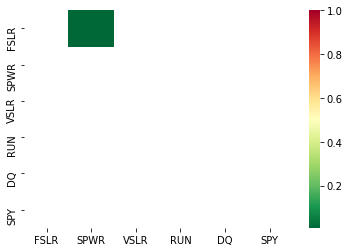

In [18]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r'  , mask = (pvalues >= 0.05) )
print (pairs)

看起来FSLR和DQ是协整的。让我们看看价格，确保没有什么奇怪的事情发生。

In [19]:
S1 = prices_df['FSLR']
S2 = prices_df['DQ']

In [20]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.011904945761108482

[*********************100%***********************]  6 of 6 completed

## 计算价差
现在我们将绘制这两个序列的分布。为了实际计算价差，我们使用线性回归得到我们两种证券之间的线性组合的系数，如[平稳度讲座](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity)所示。使用线性回归来估计系数被称为恩格尔-格兰杰方法。

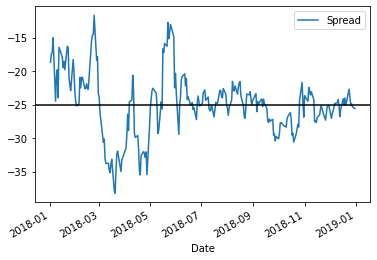

In [21]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['FSLR']
b = results.params['FSLR']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

或者，我们可以研究两个序列之间的比例。

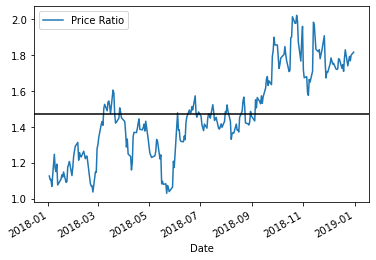

In [22]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

检验交易对的价格比率是处理交易对的传统方法。为什么这是一个信号的部分原因是基于我们对股票价格如何变化的假设，特别是因为股票价格通常被假设为对数正态分布。这意味着，通过取价格的比率，我们就得到了与之相关的回报的线性组合(因为价格只是指数回报)。

对于我们的目的来说，这可能有点令人恼火，因为购买准确的交易对比率可能不太实际。我们选择继续简单地使用线性回归计算协整股票之间的价差。然而，这是处理关系的一种非常简单的方法，对于非玩具的示例可能不可行。还有其他潜在的方法可以用来估计这节课底部列出的价差。如果你想更多地了解为什么股票对配对交易很重要，请参阅量子理论系列的[单整、协整和平稳性课程](https://www.quantopian.com/lectures#Integration,-Cointegration,-and-Stationarity)。

回到我们的例子。绝对价差在统计学上不是很有用。把我们的信号当作z分数来处理会更有帮助。

### 警告
在实践中，这通常是为了给数据提供一定的比例，但这假设了一些基本的分布，通常是正态分布。在正态分布下，我们知道大约84%的扩展值会更小。然而，许多金融数据不是正态分布的，在生成统计数据时，必须非常小心，不要假设它们是正态分布，也不要假设它们是任何特定的分布。可能的情况是，价差的真实分布非常厚尾，并倾向于极值。这可能会打乱我们的模型，并导致巨大的损失。

In [23]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

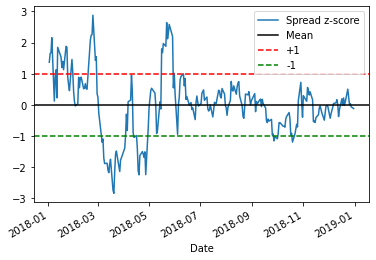

In [24]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### 简单的策略:
* 当z分数低于-1.0时，做多差价
* 当z分数高于1.0时，做空差价
* z分数接近0时的清仓

这只是冰山一角，只是一个非常简单的例子来说明这些概念。在实践中，您可能希望为S1和S2持有多少股份计算一个更优的权重。在这个笔记簿的最后列出了一些关于配对交易的额外资源

## 交易使用不断更新的统计数据
一般来说，用一个统计量来衡量整个样本容量是不好的。例如，如果市场在上升，两种证券都在上升，那么你过去3年的平均价格可能不能代表今天的情况。出于这个原因，交易员经常使用依赖于最新数据滚动窗口的统计数据。

## 移动平均
移动平均线就是每一个给定时间的最近$n$个数据点的平均值。对于本系列中的第一组$n$个数据点，它将是未定义的。较短的移动平均线将会更加波动和不可靠，但是对新信息的反应很快。更长的移动平均线会更平滑，但是需要更多的时间来吸收新的信息。

我们还需要使用滚动贝塔，滚动估计如何计算我们的差距，以保持我们所有的参数最新。

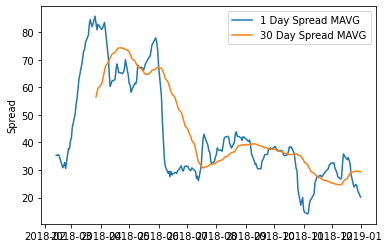

In [26]:

# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
rolling_beta = RollingOLS(S1,sm.add_constant(S2) , window=30).fit()

spread = S1 - rolling_beta.params['DQ'] * S2
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

我们可以用移动平均线来计算每个给定时间点的z分数。这将告诉我们价差有多极端，以及在这个时候入市是否是个好主意。现在我们来看看z分数。

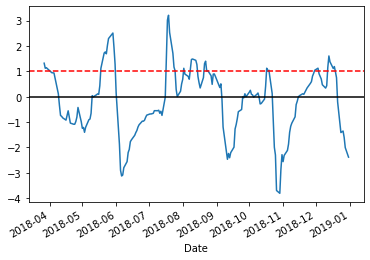

In [27]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

z分数没有太大意义，我们把它标在价格旁边，看看是什么样子。取z分数的负数，因为差价都是负数，这有点违反直觉。

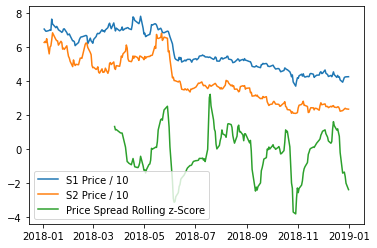

In [28]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);

## 样本外试验
现在我们已经合理地构建了我们的价差，并且对如何进行交易有了一个想法，是时候进行一些样本外测试了。我们的整个模型是建立在这些证券是协整的前提下的，但是我们是建立在一定时期的信息基础上的。如果我们真的想要实现这个模型，我们需要进行一个样本外测试来确认我们的模型的原则在未来仍然有效。

由于我们最初是在2014 - 2015年建立这个模型的，让我们看看这种协整关系是否适用于2015 - 2016年。历史结果不能保证将来的结果，所以这是一个完整性检查，看看我们所做的工作是否可靠。

In [35]:
symbol_list = ['DQ', 'FSLR']
prices_df = yf.download(symbol_list,'2019-01-01', '2020-01-01')['Close']
prices_df.columns = ['DQ', 'FSLR']

[*********************100%***********************]  2 of 2 completed


In [36]:
S1 = prices_df['DQ']
S2 = prices_df['FSLR']

In [37]:
score, pvalue, _ = coint(S1, S2)
print ('p-value: ', pvalue)

p-value:  0.6795511989865589


不幸的是，由于我们的p值高于$0.05$的临界值，我们的结论是，由于我们选择的证券之间缺乏协整，我们的模型将不再有效。如果我们试图在没有基本假设的情况下部署这个模型，我们就没有理由相信它会真正有效。样品外测试是确保我们的工作在市场上切实可行的重要一步。

## 实现
当实际执行对交易策略时，你通常希望一次交易许多不同的对。如果您通过分析数据找到了良好的配对关系，则无法保证这种关系将持续到未来。交易许多不同的组合创造了一个多样化的投资组合，以降低单个组合“跌出”协整的风险。

这节课附带了一个模板[算法](https://www.quantopian.com/lectures/example-basic-pairs-trading-algorithm)，展示了如何在我们的平台上实现配对交易的例子。你可以自由地检查它，并用你自己的配对修改它，看看你是否可以改进它。

## 进一步的研究
这本笔记本包含了一些简单的入门方法。在实践中，应该使用更复杂的统计数据，这里列出了其中的一些。

* ADF检验
* 赫斯特指数
* 从奥恩斯坦-乌伦贝克过程中推断出的均值回归的半衰期
* 卡尔曼滤波

(这*不*是背书)但是，陈可欣博士的书《算法交易:获胜策略及其理论基础》是一个非常好的学习配对交易的实用资源